In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import gensim
from tqdm import tqdm
import os
from gensim.models.fasttext import FastText

In [3]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
MAX_NB_WORDS = 500000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [6]:
cd  /content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/pretrain_models/word2vec_fasttext

/content/drive/.shortcut-targets-by-id/1bAH82a4OCCwO_0oYQxNKaht5KBDdKQGA/word2vec_fasttext


In [7]:
model_name = "./fin_word2vec"

In [8]:
model = gensim.models.Word2Vec.load(model_name)

In [9]:
import json 
traind=[]
vald=[]
dir = "/content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/data/"
# Opening JSON file 
with open(dir+'FinNum_training_v3.json',) as f: 
  traind = json.load(f) 
with open(dir+'FinNum_dev_v3.json',) as f: 
  vald = json.load(f) 

train = pd.DataFrame(traind) 
val = pd.DataFrame(vald) 
print(train.shape, val.shape)
train = train.sample(frac = 1)
val = val.sample(frac = 1)


(7187, 5) (1044, 5)


In [10]:
train.head()

,tweet,target_num,offset,target_cashtag,relation
6647,My watchlists for monday 27 Nov 2017 are as fo...,27,25,lc,0
1747,Biotechs w/ news I’m bullish &amp; buying call...,10,64,FBIO,1
4696,"$UVXY vix at 9.5 , oil will break down so all ...",9.5,13,UVXY,1
6561,$BB BlackBerry at Digital Times\nPart 2: A Can...,2,37,BB.CA,0
6033,$SLB $RIG $MRO $CVX $XOM The only trades gett...,25,128,XOM,0


In [11]:
train['aux'] = '$'+train.target_cashtag+"-"+train.target_num
val['aux'] = '$'+val.target_cashtag+"-"+val.target_num


In [12]:
train.head()

,tweet,target_num,offset,target_cashtag,relation,aux
6647,My watchlists for monday 27 Nov 2017 are as fo...,27,25,lc,0,$lc-27
1747,Biotechs w/ news I’m bullish &amp; buying call...,10,64,FBIO,1,$FBIO-10
4696,"$UVXY vix at 9.5 , oil will break down so all ...",9.5,13,UVXY,1,$UVXY-9.5
6561,$BB BlackBerry at Digital Times\nPart 2: A Can...,2,37,BB.CA,0,$BB.CA-2
6033,$SLB $RIG $MRO $CVX $XOM The only trades gett...,25,128,XOM,0,$XOM-25


In [13]:
cols = ['tweet', 'aux', 'relation' ]
train = train[cols]
val = val[cols]

In [14]:
print(train.relation.value_counts())
print(val.relation.value_counts())

1    5827
0    1360
Name: relation, dtype: int64
1    850
0    194
Name: relation, dtype: int64


In [15]:
train.head()

,tweet,aux,relation
6647,My watchlists for monday 27 Nov 2017 are as fo...,$lc-27,0
1747,Biotechs w/ news I’m bullish &amp; buying call...,$FBIO-10,1
4696,"$UVXY vix at 9.5 , oil will break down so all ...",$UVXY-9.5,1
6561,$BB BlackBerry at Digital Times\nPart 2: A Can...,$BB.CA-2,0
6033,$SLB $RIG $MRO $CVX $XOM The only trades gett...,$XOM-25,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


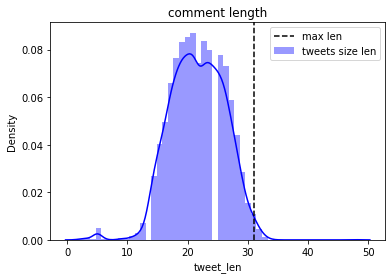

In [16]:
train['tweet_len'] = train.tweet.apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train.tweet_len.mean() + 2*train.tweet_len.std()).astype(int)

sns.distplot(train.tweet_len, hist=True, kde=True, color='b', label='tweets size len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [17]:
label_dict = {}
for index, possible_label in enumerate(train.relation.unique()):
    label_dict[possible_label] = index

l_train = train.tweet.tolist()
aux_train = train.aux.tolist()
l_test = val.tweet.tolist()
aux_test = val.aux.tolist()
num_classes = len(label_dict)


clean_train = []
for doc in tqdm(l_train):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_train.append(" ".join(filtered))

clean_train_aux = []
for doc in tqdm(aux_train):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_train_aux.append(" ".join(filtered))


clean_test = []
for doc in tqdm(l_test):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_test.append(" ".join(filtered))

clean_test_aux = []
for doc in tqdm(aux_test):
  tokens = word_tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  clean_test_aux.append(" ".join(filtered))

print("Tokenizing: ")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(clean_train + clean_train_aux+ clean_test+clean_test_aux)  

word_seq_train = tokenizer.texts_to_sequences(clean_train)
word_seq_train_aux = tokenizer.texts_to_sequences(clean_train_aux)
word_seq_test = tokenizer.texts_to_sequences(clean_test)
word_seq_test_aux = tokenizer.texts_to_sequences(clean_test_aux)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
word_seq_train_aux = sequence.pad_sequences(word_seq_train_aux, maxlen=max_seq_len)
word_seq_test_aux = sequence.pad_sequences(word_seq_test_aux, maxlen=max_seq_len)

100%|██████████| 1044/1044 [00:00<00:00, 14285.98it/s]


Tokenizing: 
dictionary size:  12180


In [18]:
word_seq_train[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  188,  722,  108,  162,  158,  134,   64,  123,  347,
       1168,  148,   61,  326,   94,   94, 1097,  665,   23], dtype=int32)

In [19]:

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [20]:
#load char model
!pip install chars2vec

     |████████████████████████████████| 8.1MB 11.3MB/s 
  Created wheel for chars2vec: filename=chars2vec-0.1.7-cp36-none-any.whl size=8111096 sha256=cf59e2797d66ad88f54ea8a6262cebd16def6306e549cf79d6601c3e200cb112
  Stored in directory: /root/.cache/pip/wheels/97/b6/65/d7e778ef1213ec77d315aea0f536068b96e36cc94c02abbfde
Successfully built chars2vec


In [21]:
import chars2vec
c2v_model = chars2vec.load_model('eng_300')

In [22]:
def get_embedding(word):
    try:
        embedding=model[word]
    except:
        embedding=c2v_model.vectorize_words([word])#np.zeros((embed_dim,))
    return embedding

In [23]:
#for word, i in word_index.items():
#    if i >= nb_words:
#        continue
#    print(word)

In [24]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = get_embedding(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        if np.sum(embedding_vector) == 0:
          words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


number of null word embeddings: 1


In [25]:
print(words_not_found[50:100])

[]


In [26]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, concatenate, add, merge, multiply, dot
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, Input, TimeDistributed

In [27]:
# avoid model to overwrite
keras.backend.clear_session()

In [28]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

sentence_in = Input(shape=(max_seq_len, ), dtype='int32', name="tweet")
sent_embedding_layer = Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False) (sentence_in)
lstm_sentence = Bidirectional(LSTM(256))(sent_embedding_layer)



aspects_in = Input(shape=(max_seq_len,), dtype='int32', name="aux")
aspects_embedding_layer = Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False) (aspects_in)
lstm_aspects = Bidirectional(LSTM(256))(aspects_embedding_layer)


x = concatenate([sent_embedding_layer, aspects_embedding_layer])
x = Bidirectional(LSTM(256, return_sequences=True)) (x)
x = Bidirectional(LSTM(256)) (x)
x=  Dropout(.3) (x)
x = Dense(1024,activation='relu')(x)
x=  Dropout(.3) (x)
x = Dense(128,activation='relu')(x)
x=  Dropout(.3) (x)
preds = Dense(1,activation= 'sigmoid')(x)

model = tf.keras.Model(inputs=[sentence_in, aspects_in], outputs=preds)

dot_img_file = '/content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/data/model_classif_embed_concat.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tweet (InputLayer)              [(None, 31)]         0                                            
__________________________________________________________________________________________________
aux (InputLayer)                [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 300)      3654300     tweet[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 31, 300)      3654300     aux[0][0]                        
_______________________________________________________________________________________

In [29]:
if 0:
  from keras.layers import BatchNormalization
  import tensorflow as tf

  model = tf.keras.Sequential()

  model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(256,return_sequences= True)))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(256,return_sequences= True)))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(256)))
  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()

In [30]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

In [31]:
!pwd

/content/drive/.shortcut-targets-by-id/1bAH82a4OCCwO_0oYQxNKaht5KBDdKQGA/word2vec_fasttext


In [32]:
checkpoint = ModelCheckpoint('word2vec_finetune_classification_weights_embed_v3.best.hdf5',
                             verbose=1,
                             save_weights_only=True,
                             monitor = 'val_loss',
                             mode='min',
                             save_best_only=True)
es_callback = EarlyStopping(monitor='val_loss', patience=5, mode="min")

In [33]:
#es_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode="max")
#training params
batch_size = 32 
num_epochs = 30

history = model.fit([word_seq_train, word_seq_train_aux], train.relation.values, batch_size=batch_size,
          epochs=num_epochs, validation_data=([word_seq_test, word_seq_test_aux], val.relation.values),
          callbacks=[es_callback, checkpoint])

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


224/225 [============================>.] - ETA: 0s - loss: 0.4272 - accuracy: 0.8174
Epoch 00001: val_loss improved from inf to 0.31425, saving model to word2vec_finetune_classification_weights_embed_v3.best.hdf5
225/225 [==============================] - 11s 48ms/step - loss: 0.4272 - accuracy: 0.8174 - val_loss: 0.3143 - val_accuracy: 0.8496
Epoch 2/30
224/225 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8465
Epoch 00002: val_loss did not improve from 0.31425
225/225 [==============================] - 11s 49ms/step - loss: 0.3587 - accuracy: 0.8469 - val_loss: 0.3452 - val_accuracy: 0.8697
Epoch 3/30
225/225 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8796
Epoch 00003: val_loss improved from 0.31425 to 0.28354, saving model to word2vec_finetune_classification_weights_embed_v3.best.hdf5
225/225 [==============================] - 11s 49ms/step - loss: 0.3021 - accuracy: 0.8796 - val_loss: 0.2835 - val_accuracy: 0.8860
Epoch 4/30
22

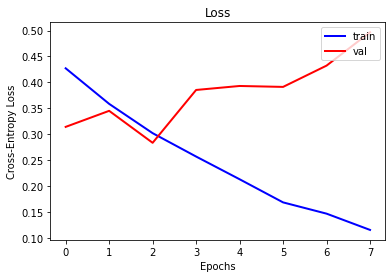

In [42]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

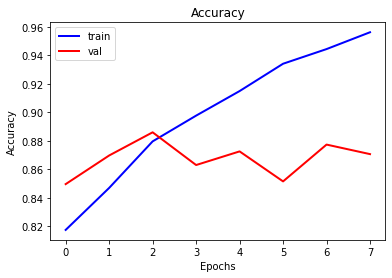

In [35]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [43]:

model.load_weights('word2vec_finetune_classification_weights_embed_v3.best.hdf5')

In [44]:
predictions = model.predict([word_seq_test, word_seq_test_aux])
predictions = (predictions > 0.5).astype('int32')
predictions = predictions.ravel()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [38]:
dir = "/content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/data/"

In [39]:
val['pred'] = predictions
val.to_csv(dir+"word2vec_finetune_classification_v3_concat_embed.csv")

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(np.array(val.relation.values), predictions, labels=[0,1]))
print(classification_report(np.array(val.relation.values), predictions))

[[ 94 100]
 [ 19 831]]
              precision    recall  f1-score   support

           0       0.83      0.48      0.61       194
           1       0.89      0.98      0.93       850

    accuracy                           0.89      1044
   macro avg       0.86      0.73      0.77      1044
weighted avg       0.88      0.89      0.87      1044



In [41]:
predictions = model.predict([word_seq_train, word_seq_train_aux])
predictions = predictions.ravel()
predictions = [1 if pred>.5 else 0 for pred in predictions]
print(confusion_matrix(np.array(train.relation.values), predictions, labels=[0,1]))
print(classification_report(np.array(train.relation.values), predictions))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[[ 925  435]
 [ 212 5615]]
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1360
           1       0.93      0.96      0.95      5827

    accuracy                           0.91      7187
   macro avg       0.87      0.82      0.84      7187
weighted avg       0.91      0.91      0.91      7187

